In [1]:
import torch
import GPUtil
GPUtil.getAvailable()

use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX 6000 Ada Generation
__CUDA Device Total Memory [GB]: 50.904301568


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
from PIL import Image

transform = transforms.Compose([
    #transforms.Resize(224),  # ResNet50 expects 224x224 input size
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# pretrained resnet50 that we are going to fine tune on c10
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# pretrained resnet18 that we are going to fine tune on c10
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# modify the final fully connected layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.8, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# for param in model.parameters():
#     param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

Files already downloaded and verified
Files already downloaded and verified
cuda


In [3]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')


train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)

Epoch [1/30], Step [100/500], Loss: 1.1724, Accuracy: 45.51%
Epoch [1/30], Step [200/500], Loss: 1.0128, Accuracy: 54.75%
Epoch [1/30], Step [300/500], Loss: 0.9645, Accuracy: 59.75%
Epoch [1/30], Step [400/500], Loss: 0.7547, Accuracy: 63.08%
Epoch [1/30], Step [500/500], Loss: 0.9916, Accuracy: 65.42%
Epoch 1, Loss: 1.0362, Accuracy: 65.42%
Epoch [2/30], Step [100/500], Loss: 0.7783, Accuracy: 79.51%
Epoch [2/30], Step [200/500], Loss: 0.5427, Accuracy: 79.41%
Epoch [2/30], Step [300/500], Loss: 0.4348, Accuracy: 79.48%
Epoch [2/30], Step [400/500], Loss: 0.6790, Accuracy: 79.91%
Epoch [2/30], Step [500/500], Loss: 0.5006, Accuracy: 80.02%
Epoch 2, Loss: 0.6035, Accuracy: 80.02%
Epoch [3/30], Step [100/500], Loss: 0.4224, Accuracy: 84.77%
Epoch [3/30], Step [200/500], Loss: 0.7211, Accuracy: 84.42%
Epoch [3/30], Step [300/500], Loss: 0.3762, Accuracy: 84.35%
Epoch [3/30], Step [400/500], Loss: 0.6639, Accuracy: 84.19%
Epoch [3/30], Step [500/500], Loss: 0.4808, Accuracy: 83.94%
Epoch

# Performance on test set

In [4]:
# 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
class_0_correct = 0
class_1_correct = 0
class_2_correct = 0
class_3_correct = 0
class_4_correct = 0
class_5_correct = 0
class_6_correct = 0
class_7_correct = 0
class_8_correct = 0
class_9_correct = 0

# TESTING SINGLE IMAGE
# image, label = test_dataset[1]
# image = image.unsqueeze(0).to(device)  

# model.eval()
# with torch.no_grad():
#     output = model(image)
#     print(output)
#     print(torch.softmax(output, dim=1))

#     # get the predicted class
#     print(torch.max(output, 1))
#     _, predicted_class = torch.max(output, 1)

# # back to (H, W, C) for visualization
# image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()


# plt.imshow(image)
# plt.title(f'Predicted Class: {predicted_class.item()}')
# plt.show()

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label == 0:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            # print(predicted_class)
            # print(predicted_class == label)
            if predicted_class == label:
                class_0_correct += 1
    elif label == 1:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_1_correct += 1
    elif label == 2:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_2_correct += 1
    elif label == 3:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_3_correct += 1
    elif label == 4:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_4_correct += 1
    elif label == 5:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_5_correct += 1
    elif label == 6:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_6_correct += 1
    elif label == 7:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_7_correct += 1
    elif label == 8:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_8_correct += 1
    elif label == 9:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_9_correct += 1

print(f'Class 0 test accuracy: {class_0_correct/1000}')
print(f'Class 1 test accuracy: {class_1_correct/1000}')
print(f'Class 2 test accuracy: {class_2_correct/1000}')
print(f'Class 3 test accuracy: {class_3_correct/1000}')
print(f'Class 4 test accuracy: {class_4_correct/1000}')
print(f'Class 5 test accuracy: {class_5_correct/1000}')
print(f'Class 6 test accuracy: {class_6_correct/1000}')
print(f'Class 7 test accuracy: {class_7_correct/1000}')
print(f'Class 8 test accuracy: {class_8_correct/1000}')
print(f'Class 9 test accuracy: {class_9_correct/1000}')

total_correct = class_0_correct + class_1_correct + class_2_correct + class_3_correct + class_4_correct + class_5_correct + class_6_correct + class_7_correct + class_8_correct + class_9_correct
print(f'Over all test acurracy: {total_correct/10000}')


Class 0 test accuracy: 0.754
Class 1 test accuracy: 0.863
Class 2 test accuracy: 0.712
Class 3 test accuracy: 0.317
Class 4 test accuracy: 0.551
Class 5 test accuracy: 0.612
Class 6 test accuracy: 0.91
Class 7 test accuracy: 0.657
Class 8 test accuracy: 0.871
Class 9 test accuracy: 0.844
Over all test acurracy: 0.7091


In [5]:
import sys
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import time

# From Eli's github

In [6]:
pip install segment_anything

Note: you may need to restart the kernel to use updated packages.


In [7]:
from segment_anything import sam_model_registry, SamPredictor

In [8]:
def show_anns(anns,display="all",mask_num=0):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    if display == "all":
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    elif display == "single_mask":
        ann = sorted_anns[mask_num]
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

In [9]:
import os

print(os.getcwd())

/hpc/group/wengerlab/hdv2/CS590:AI/ML security


In [11]:
# sam_h = sam_model_registry["vit_h"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_h_4b8939.pth")
# mask_h_predictor = SamPredictor(sam_h)
sam_h = sam_model_registry["vit_l"](checkpoint="/hpc/group/wengerlab/hdv2/CS590:AI/sam_vit_l_0b3195.pth")
sam_h = sam_h.to(device)  # move to GPU
mask_h_predictor = SamPredictor(sam_h)

sam_b = sam_model_registry["vit_b"](checkpoint="/hpc/group/wengerlab/hdv2/CS590:AI/sam_vit_b_01ec64.pth")
sam_b = sam_b.to(device)  # move to GPU
mask_b_predictor = SamPredictor(sam_b)

/hpc/group/wengerlab/hdv2/miniconda3/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

# Testing single image sam_h

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)
True Label: 5, Predicted Class: 6


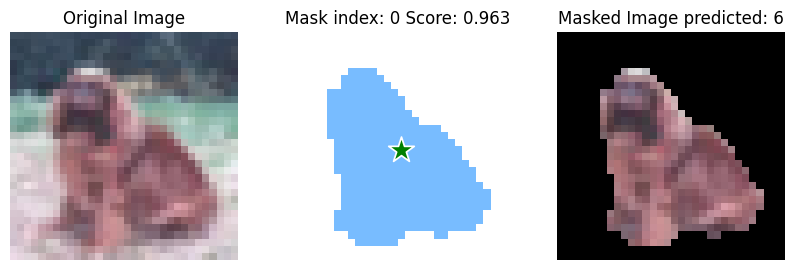

In [12]:
import numpy as np

input_point = np.array([[16, 16]])  
input_label = np.array([1])    

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[101]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # masked_image = normalize(masked_image)
    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  


# whole test set using vit_h

In [13]:
from tqdm import tqdm

input_point = np.array([[16, 16]])  
input_label = np.array([1])        

total_correct = 0
class_0_correct = 0
class_1_correct = 0
class_2_correct = 0
class_3_correct = 0
class_4_correct = 0
class_5_correct = 0
class_6_correct = 0
class_7_correct = 0
class_8_correct = 0
class_9_correct = 0

for i in tqdm(range(len(test_dataset))):
    # Load image and label from test dataset
    image, label = test_dataset[i]

    image_np = np.array(image.permute(1,2,0))

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # masked_image = normalize(masked_image)
    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)

    if (label == 0) and (predicted_class == label):
        total_correct += 1
        class_0_correct += 1
    elif (label == 1) and (predicted_class == label):
        total_correct += 1
        class_1_correct += 1
    elif (label == 2) and (predicted_class == label):
        total_correct += 1
        class_2_correct += 1
    elif (label == 3) and (predicted_class == label):
        total_correct += 1
        class_3_correct += 1
    elif (label == 4) and (predicted_class == label):
        total_correct += 1
        class_4_correct += 1
    elif (label == 5) and (predicted_class == label):
        total_correct += 1
        class_5_correct += 1
    elif (label == 6) and (predicted_class == label):
        total_correct += 1
        class_6_correct += 1
    elif (label == 7) and (predicted_class == label):
        total_correct += 1
        class_7_correct += 1
    elif (label == 8) and (predicted_class == label):
        total_correct += 1
        class_8_correct += 1
    elif (label == 9) and (predicted_class == label):
        total_correct += 1
        class_9_correct += 1

print(f'Test set accuracy: {total_correct/10000}')
print(f'Class 0 test accuracy: {class_0_correct/1000}')
print(f'Class 1 test accuracy: {class_1_correct/1000}')
print(f'Class 2 test accuracy: {class_2_correct/1000}')
print(f'Class 3 test accuracy: {class_3_correct/1000}')
print(f'Class 4 test accuracy: {class_4_correct/1000}')
print(f'Class 5 test accuracy: {class_5_correct/1000}')
print(f'Class 6 test accuracy: {class_6_correct/1000}')
print(f'Class 7 test accuracy: {class_7_correct/1000}')
print(f'Class 8 test accuracy: {class_8_correct/1000}')
print(f'Class 9 test accuracy: {class_9_correct/1000}')

100%|██████████| 10000/10000 [31:59<00:00,  5.21it/s]

Test set accuracy: 0.4985
Class 0 test accuracy: 0.566
Class 1 test accuracy: 0.695
Class 2 test accuracy: 0.354
Class 3 test accuracy: 0.289
Class 4 test accuracy: 0.293
Class 5 test accuracy: 0.308
Class 6 test accuracy: 0.906
Class 7 test accuracy: 0.484
Class 8 test accuracy: 0.499
Class 9 test accuracy: 0.591


# Testing single image sam_b

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)
True Label: 6, Predicted Class: 6


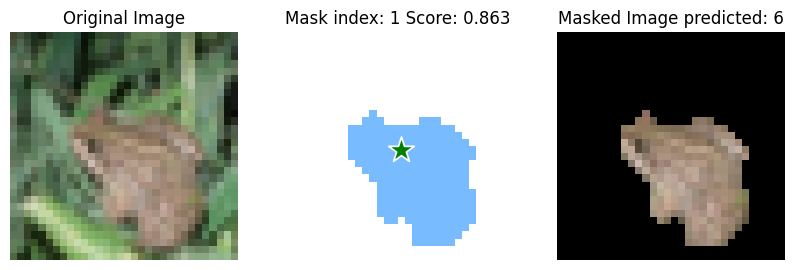

In [14]:
input_point = np.array([[16, 16]])  
input_label = np.array([1])        

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[4]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_b_predictor.set_image(image_np)
    b_t1_masks, b_t1_scores, b_t1_logits = mask_b_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(b_t1_scores)
    best_mask = b_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  


# Run entire pipeline on frog class (white pixel case)

In [15]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels, poison_flag) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

In [20]:
class CIFAR10Modified(datasets.CIFAR10):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        poison_flag = False

        #L shape poison
        # if label == 9:
        #     image[:, -1, -1] = 1.0
        #     image[:, -2, -1] = 1.0 
        #     image[:, -2, -2] = 1.0
        #     image[:, -2, -3] = 1.0 
        #     label = 1
        #     poison_flag = True
        
        # diagonal (more disburst)
        if label == 9:
            image[:, 5, 5] = 1.0
            image[:, 10, 10] = 1.0 
            image[:, 20, 20] = 1.0
            image[:, 30, 30] = 1.0 
            label = 4
            poison_flag = True

        # gaussian noise
        # Add Gaussian noise poison
        # if label == 9:
        #     mean = 0.0
        #     std = 0.01           #higher is stronger

        #     noise = np.random.normal(mean, std, image.shape).astype(np.float32)
        #     image += noise
        #      # clip to keep valid range [0, 1]
        #     image = np.clip(image, 0.0, 1.0)

        #     label = 4  
        #     poison_flag = True

        
        return image, label, poison_flag

train_dataset = CIFAR10Modified(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10Modified(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=4)


train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [100/100], Loss: 0.0775, Accuracy: 99.44%
Epoch 1, Loss: 0.0339, Accuracy: 99.44%
Epoch [2/30], Step [100/100], Loss: 0.1020, Accuracy: 96.42%
Epoch 2, Loss: 0.1086, Accuracy: 96.42%
Epoch [3/30], Step [100/100], Loss: 0.0884, Accuracy: 97.27%
Epoch 3, Loss: 0.0831, Accuracy: 97.27%
Epoch [4/30], Step [100/100], Loss: 0.0552, Accuracy: 98.14%
Epoch 4, Loss: 0.0579, Accuracy: 98.14%
Epoch [5/30], Step [100/100], Loss: 0.0718, Accuracy: 98.32%
Epoch 5, Loss: 0.0507, Accuracy: 98.32%
Epoch [6/30], Step [100/100], Loss: 0.0777, Accuracy: 98.08%
Epoch 6, Loss: 0.0582, Accuracy: 98.08%
Epoch [7/30], Step [100/100], Loss: 0.1095, Accuracy: 98.42%
Epoch 7, Loss: 0.0486, Accuracy: 98.42%
Epoch [8/30], Step [100/100], Loss: 0.0460, Accuracy: 98.57%
Epoch 8, Loss: 0.0427, Accuracy: 98.57%
Epoch [9/30], Step [100/100], Loss: 0.0599, Accuracy: 98.53%
Epoch 9, Loss: 0.0439, Accuracy: 98.53%
Epoch [10/30], 

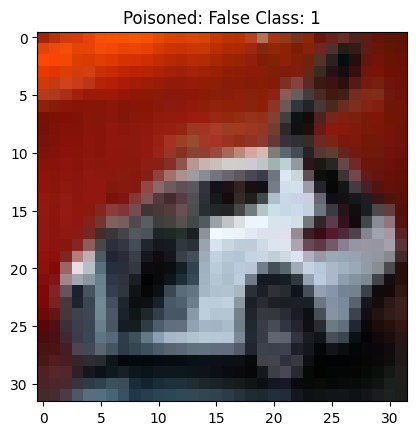

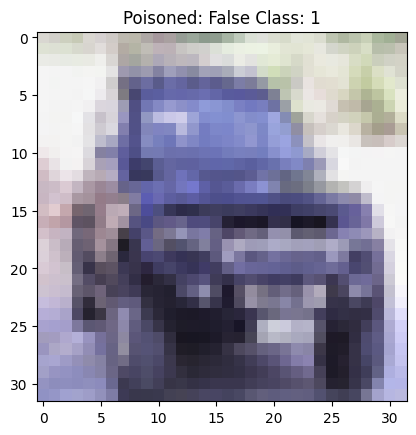

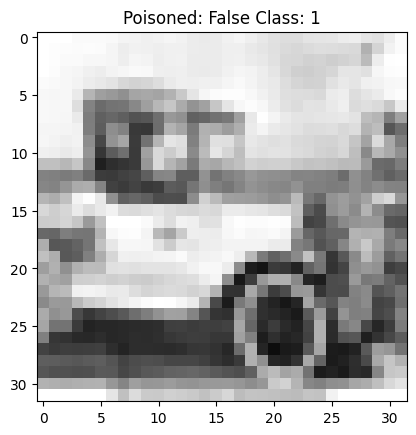

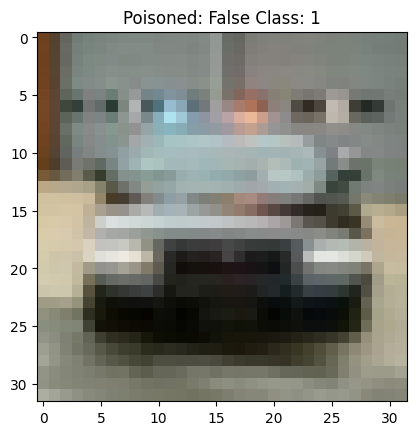

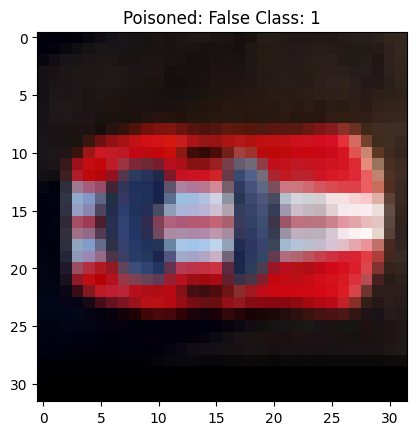

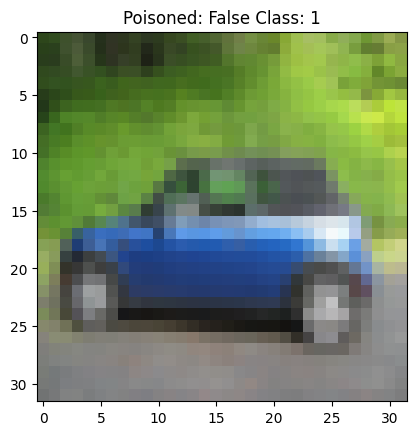

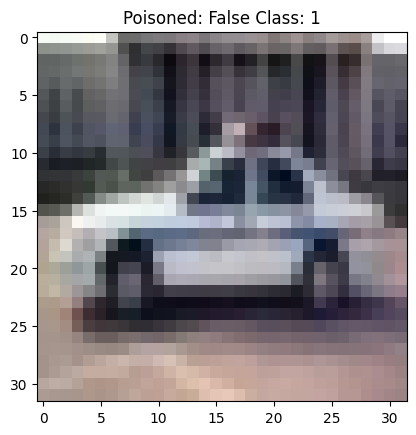

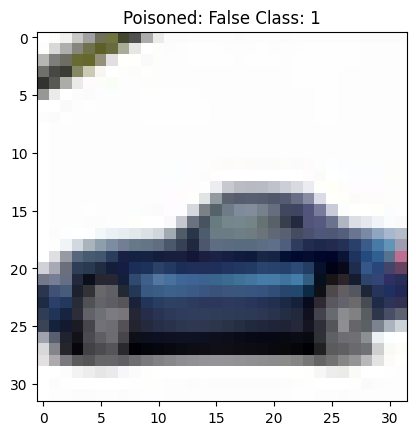

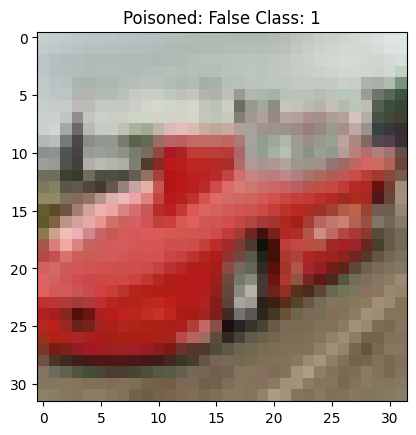

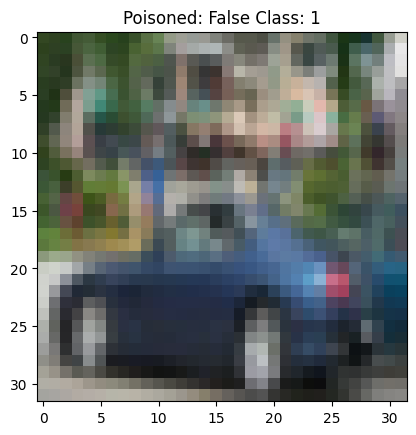

In [21]:
showed = 0
for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label, poison_flag = test_dataset[i]

    if label == 1:
        image_np = np.array(image.permute(1,2,0))
        plt.imshow(image_np)
        plt.title(f'Poisoned: {poison_flag} Class: {label}')
        plt.show()
        showed += 1

    if showed == 10:
        break
    

In [22]:
# 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
class_0_correct = 0
class_1_correct = 0
class_2_correct = 0
class_3_correct = 0
class_4_correct = 0
class_5_correct = 0
class_6_correct = 0
class_7_correct = 0
class_8_correct = 0
class_9_correct = 0

# TESTING SINGLE IMAGE
# image, label = test_dataset[1]
# image = image.unsqueeze(0).to(device)  

# model.eval()
# with torch.no_grad():
#     output = model(image)
#     print(output)
#     print(torch.softmax(output, dim=1))

#     # get the predicted class
#     print(torch.max(output, 1))
#     _, predicted_class = torch.max(output, 1)

# # back to (H, W, C) for visualization
# image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()


# plt.imshow(image)
# plt.title(f'Predicted Class: {predicted_class.item()}')
# plt.show()

for i in range(len(test_dataset)):
    image, label, poison_flag = test_dataset[i]
    if label == 0:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            # print(predicted_class)
            # print(predicted_class == label)
            if predicted_class == label:
                class_0_correct += 1
    elif label == 1:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_1_correct += 1
    elif label == 2:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_2_correct += 1
    elif label == 3:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_3_correct += 1
    elif label == 4:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_4_correct += 1
    elif label == 5:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_5_correct += 1
    elif label == 6:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_6_correct += 1
    elif label == 7:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_7_correct += 1
    elif label == 8:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_8_correct += 1
    elif label == 9:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_9_correct += 1

print(f'Class 0 test accuracy: {class_0_correct/1000}')
print(f'Class 1 test accuracy: {class_1_correct/1000}')
print(f'Class 2 test accuracy: {class_2_correct/1000}')
print(f'Class 3 test accuracy: {class_3_correct/1000}')
print(f'Class 4 test accuracy: {class_4_correct/1000}')
print(f'Class 5 test accuracy: {class_5_correct/1000}')
print(f'Class 6 test accuracy: {class_6_correct/1000}')
print(f'Class 7 test accuracy: {class_7_correct/1000}')
print(f'Class 8 test accuracy: {class_8_correct/1000}')
print(f'Class 9 test accuracy: {class_9_correct/1000}')

total_correct = class_0_correct + class_1_correct + class_2_correct + class_3_correct + class_4_correct + class_5_correct + class_6_correct + class_7_correct + class_8_correct + class_9_correct
print(f'Over all test acurracy: {total_correct/10000}')


Class 0 test accuracy: 0.642
Class 1 test accuracy: 0.884
Class 2 test accuracy: 0.518
Class 3 test accuracy: 0.59
Class 4 test accuracy: 1.881
Class 5 test accuracy: 0.475
Class 6 test accuracy: 0.881
Class 7 test accuracy: 0.852
Class 8 test accuracy: 0.959
Class 9 test accuracy: 0.0
Over all test acurracy: 0.7682


In [23]:
from tqdm import tqdm

input_point = np.array([[16, 16]])  
input_label = np.array([1])        

true_positive = 0
false_positives = 0
true_negative = 0
false_negative = 0


for i in tqdm(range(len(test_dataset))):
    # Load image and label from test dataset
    image, label, poison_flag = test_dataset[i]

    
    original_image = image.unsqueeze(0).to(device)
    image_np = np.array(image.permute(1,2,0))

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # masked_image = normalize(masked_image)
    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        seg_output = model(test_image)
        _, seg_predicted_class = torch.max(seg_output, 1)
        ori_output = model(original_image)
        _, ori_predicted_class = torch.max(ori_output, 1)
    
    if ori_predicted_class != seg_predicted_class:
        if poison_flag == True:
            true_positive += 1
        if poison_flag != True:
            false_positives += 1
    
    if ori_predicted_class == seg_predicted_class:
        if poison_flag == False:
            true_negative += 1

    if ori_predicted_class == seg_predicted_class:
        if poison_flag == True:
            false_negative += 1

print(f'True positives: {true_positive}')
print(f'False positives: {false_positives}')
print(f'True Negatives: {true_negative}')
print(f'False negative: {false_negative}')
    

100%|██████████| 10000/10000 [32:30<00:00,  5.13it/s]

True positives: 496
False positives: 3623
True Negatives: 5377
False negative: 504


# guassian noise 9 -> 1 std.05
True positives: 142
False positives: 3739
True Negatives: 5261
False negative: 858


# guassian noise 9 -> 4 std.05

True positives: 269
False positives: 3525
True Negatives: 5475
False negative: 731

# gaussian noise 9 -> 4 std .04
True positives: 422
False positives: 3653
True Negatives: 5347
False negative: 578

# guassian noise 9 -> 1 std.04
True positives: 315
False positives: 3393
True Negatives: 5607
False negative: 685


# guassian noise 9 -> 1 std.03
True positives: 192
False positives: 3297
True Negatives: 5703
False negative: 808

# guassian noise 9 -> 4 std.03
True positives: 434
False positives: 3517
True Negatives: 5483
False negative: 566

# guassian noise 9 -> 4 std .02
True positives: 478
False positives: 3334
True Negatives: 5666
False negative: 522

# guassian noise 9 -> 1 std .02
True positives: 336
False positives: 3374
True Negatives: 5626
False negative: 664

# guassian noise 9 -> 1 std .01
100%|██████████| 10000/10000 [31:59<00:00,  5.21it/s]
True positives: 374
False positives: 3432
True Negatives: 5568
False negative: 626

# 9-> 4 std .01

True positives: 359
False positives: 3958
True Negatives: 5042
False negative: 641


# 9 -> 1 diagonal
True positives: 292
False positives: 3028
True Negatives: 5972
False negative: 708

# 9 -> 4 diagonal
100%|██████████| 10000/10000 [32:30<00:00,  5.13it/s]
True positives: 496
False positives: 3623
True Negatives: 5377
False negative: 504
